<a href="https://colab.research.google.com/github/mcgrammar86/LOPL_YA_Diversity_Audit/blob/main/YA_audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('seaborn')
mpl.rcParams['axes.facecolor'] = 'w'
mpl.rcParams['axes.grid'] = False
mpl.rcParams['grid.color'] = 'lightgray'

/bin/bash: matplotlib: command not found


In [2]:
audit_df = pd.read_csv('https://raw.githubusercontent.com/mcgrammar86/LOPL_YA_Diversity_Audit/main/YAFIC%20Diversity%20Audit.csv')


**Let's start by having a quick look at the first 5 rows of our data, and a quick overview of the information that's contained therein.**

In [3]:
audit_df.head()

,Author,Item Barcode,Catalog Title,Total Charges,Item Created Date,Black,Asian,Latinx,Indigenous,White,Pacific Islander/Native Hawaiian,Refugee/Immigrant,Gender Roles,LGBTQ+,Family Structure,Adoption/Foster,Homeless,Socio-Economic,Ability Diverse,Neurodiversity,Mental Illness,Health Concerns,Culture/Religion,Judaism,Islam/Muslim,Hinduism,Own Voices
0,"YA-GARCIA, KAMI",54858717.0,Beautiful darkness /,29.0,8/13/2013,NaN,NaN,x,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x
1,"YA-ABAWI, ATIA",55986129.0,The secret sky /,10.0,8/28/2014,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,x,NaN,x
2,"YA-ABAWI, ATIA",70010731.0,A land of permanent goodbyes /,9.0,1/30/2018,NaN,x,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,x
3,"YA-ABBOTT, TONY",70471990.0,Junk Boy,0.0,10/20/2020,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,x,x,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"YA-ABDEL-FATTAH, RANDA",46381760.0,Does my head look big in this? /,98.0,5/25/2007,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,x,NaN,x


**No need for the "YA-" before the author's name, or the slash at the end of the book titles. Let's remove them.**

In [4]:
audit_df['Author'] = audit_df['Author'].str.replace('YA-','')
audit_df['Catalog Title'] = audit_df['Catalog Title'].str.replace(' /','')

In [5]:
audit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2284 entries, 0 to 2283
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Author                            2284 non-null   object 
 1   Item Barcode                      2283 non-null   float64
 2   Catalog Title                     2284 non-null   object 
 3   Total Charges                     2283 non-null   float64
 4   Item Created Date                 2282 non-null   object 
 5   Black                             423 non-null    object 
 6   Asian                             503 non-null    object 
 7   Latinx                            337 non-null    object 
 8   Indigenous                        28 non-null     object 
 9   White                             1843 non-null   object 
 10  Pacific Islander/Native Hawaiian  23 non-null     object 
 11  Refugee/Immigrant                 44 non-null     object 
 12  Gender

**We find that there are 5 basic cataloging datapoints, along with 22 categories being tracked by the diversity audit. The categories are not encoded as boolean values, but as either an "x" to mark that category's presence within a work, or a missing value in its absence. Let's convert those to boolean values.**

In [6]:
audit_columns = ['Black', 'Asian', 'Latinx', 'Indigenous', 'White',
       'Pacific Islander/Native Hawaiian', 'Refugee/Immigrant', 'Gender Roles',
       'LGBTQ+', 'Family Structure', 'Adoption/Foster', 'Homeless',
       'Socio-Economic', 'Ability Diverse', 'Neurodiversity', 'Mental Illness',
       'Health Concerns', 'Culture/Religion', 'Judaism', 'Islam/Muslim',
       'Hinduism', 'Own Voices']

for col in audit_columns:
  audit_df[col] = (audit_df[col] == 'x')

**Let's add up the number of categories present for each title to create a rough "diversity score" metric.**

In [7]:
audit_df['diversity_score'] = audit_df[audit_columns].sum(axis=1)
audit_df['diversity_score'].value_counts().sort_index()

0      76
1     923
2     550
3     353
4     199
5     119
6      39
7      15
8       4
9       4
10      1
12      1
Name: diversity_score, dtype: int64

**There are 76 titles with no diversity category flagged as being present. This seems unusual. Let's look at what titles are present.**

In [8]:
audit_df.loc[audit_df['diversity_score']==0, 'Catalog Title'].values

array(['Speak', 'The assassination of Brangwain Spurge', 'Alone',
       'King of scars', 'Siege and storm', 'Crooked kingdom',
       'Ruin and rising', 'Frozen', 'Being Nikki', 'Honor among thieves',
       'Paper and fire', 'Sun warrior', 'Hunted', 'The go-between',
       'Caster', 'The wizard heir', 'The sorcerer heir',
       'Ready player one', 'Catching fire', '29 dates', 'Pet',
       'If I stay', 'How (not) to ask a boy to prom', 'Eve & Adam',
       'Front lines', 'BZRK', 'BZRK reloaded', 'Lost stars',
       'Shadow scale', 'The body in the woods', 'The courage of Elfina',
       'Truly devious', 'The story of Owen : dragon slayer of Trondheim',
       'To kill a mockingbird', 'Strange relations', 'We were liars',
       'The power of Six', 'Queen of shadows', 'Nameless queen',
       'Soundless', 'Fireborne', 'Dairy queen', 'Before I fall',
       'Animal farm : a fairy story', 'Eragon', 'Tales from Alagaësia.',
       'Eldest', 'The angel experiment', 'Maximum Ride foreve

**Some of these titles, such as "To Kill A Mockingbird" would likely have at least one category marked as present. Many might be fantasy, but with no further information available, it is unclear if the absence of any diversity category is correct. Let's export a copy of these titles to provide to the library for further inquiry.**

In [9]:
audit_df.loc[audit_df['diversity_score']==0, ['Author', 'Catalog Title','Item Barcode']].to_csv('diversity_audit_no_data.csv')

**For now, let's remove titles with no diversity categories present until we get further information.**

In [10]:
audit_df = audit_df[audit_df['diversity_score'] > 0]

**Lastly, let's check to be sure there are no duplicate entries.**

In [11]:
print("There are {} entries in the dataframe.".format(audit_df.shape[0]))
print("There are {} unique titles in the dataframe.".format(audit_df['Catalog Title'].nunique()))
print("There are {} unique barcodes in the dataframe.".format(audit_df['Item Barcode'].nunique()))

There are 2208 entries in the dataframe.
There are 2185 unique titles in the dataframe.
There are 2207 unique barcodes in the dataframe.


**We have some duplicate titles, but some of this may just be coincidence. Let's drop duplicates that share Author, Catalog Title, and diversity_score, and then have a closer look.**

In [12]:
audit_df = audit_df.drop_duplicates(subset=['Catalog Title' ,'Author','diversity_score'])
title_counts = audit_df.value_counts('Catalog Title')
duplicate_titles = title_counts[title_counts>1].index
audit_df[audit_df['Catalog Title'].isin(duplicate_titles)][['Author','Catalog Title','diversity_score']].sort_values('Catalog Title')

,Author,Catalog Title,diversity_score
128,"BAKER, CHANDLER",Alive,2
1917,"SIGLER, SCOTT",Alive,1
1502,"NESS, PATRICK",Burn,4
1035,"JURY, WALTER #2",Burn,1
2192,"WHEELER, THOMAS",Cursed,1
1923,"SILVERSTEIN, KAROL RUTH",Cursed,4
90,"ARMENTROUT, JENNIFER L.",Cursed,2
777,"GILES, GAIL",Girls like us,3
1640,"PINK, RANDI",Girls like us,4
1456,"MORGAN, KASS #1",Light years,3


**Most of the above titles are unique, with the exceptions of *Papertowns* and *The Fault in Our Stars* by John Green and *Wintergirls* by Laurie Halse Anderson. We'll take a quick peak at each to be sure we retain the correct record.**

In [13]:
# Papertowns by John Green
audit_df.loc[[830,833]]

,Author,Item Barcode,Catalog Title,Total Charges,Item Created Date,Black,Asian,Latinx,Indigenous,White,Pacific Islander/Native Hawaiian,Refugee/Immigrant,Gender Roles,LGBTQ+,Family Structure,Adoption/Foster,Homeless,Socio-Economic,Ability Diverse,Neurodiversity,Mental Illness,Health Concerns,Culture/Religion,Judaism,Islam/Muslim,Hinduism,Own Voices,diversity_score
830,"GREEN, JOHN",56941032.0,Paper towns,51.0,7/24/2015,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2
833,"GREEN, JOHN",70213046.0,Paper towns,16.0,8/8/2018,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1


In [14]:
# The Fault in Our Stars by John Green
audit_df.loc[[827,831]]

,Author,Item Barcode,Catalog Title,Total Charges,Item Created Date,Black,Asian,Latinx,Indigenous,White,Pacific Islander/Native Hawaiian,Refugee/Immigrant,Gender Roles,LGBTQ+,Family Structure,Adoption/Foster,Homeless,Socio-Economic,Ability Diverse,Neurodiversity,Mental Illness,Health Concerns,Culture/Religion,Judaism,Islam/Muslim,Hinduism,Own Voices,diversity_score
827,"GREEN, JOHN",54856141.0,The fault in our stars,83.0,5/5/2014,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1
831,"GREEN, JOHN",65041741.0,The fault in our stars,46.0,9/11/2017,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,2


In [15]:
# Wintergirls by Laurie Halse Anderson
audit_df.loc[[70,74]]

,Author,Item Barcode,Catalog Title,Total Charges,Item Created Date,Black,Asian,Latinx,Indigenous,White,Pacific Islander/Native Hawaiian,Refugee/Immigrant,Gender Roles,LGBTQ+,Family Structure,Adoption/Foster,Homeless,Socio-Economic,Ability Diverse,Neurodiversity,Mental Illness,Health Concerns,Culture/Religion,Judaism,Islam/Muslim,Hinduism,Own Voices,diversity_score
70,"ANDERSON, LAURIE HALSE",48830210.0,Wintergirls,103.0,2/23/2009,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,3
74,"ANDERSON, LAURIE HALSE",65103996.0,Wintergirls,5.0,4/5/2018,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,4


**After revewing, we can safely keep each record that has the higher diversity score.**

In [16]:
audit_df = audit_df.drop(labels=[833, 827, 70], axis=0)

**Now that we have a cleaned dataset, we can examine the relative frequency of each diversity category's presence within the collection.**

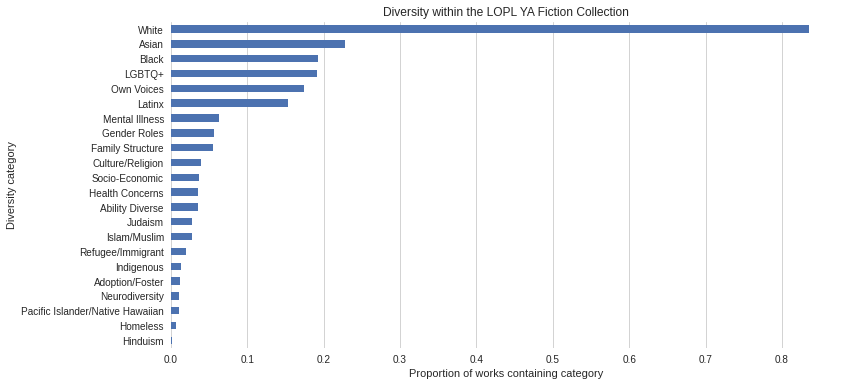

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
audit_df[audit_columns].mean(axis=0).sort_values().plot.barh()
plt.title('Diversity within the LOPL YA Fiction Collection')
ax.set_xlabel('Proportion of works containing category')
ax.set_ylabel('Diversity category')
plt.grid(axis='x')
plt.show()

**Works featuring white charaters or white perspectives feature very heavily - about 80% of the collection. We can zoom in on the other categories for a clearer look at them.**

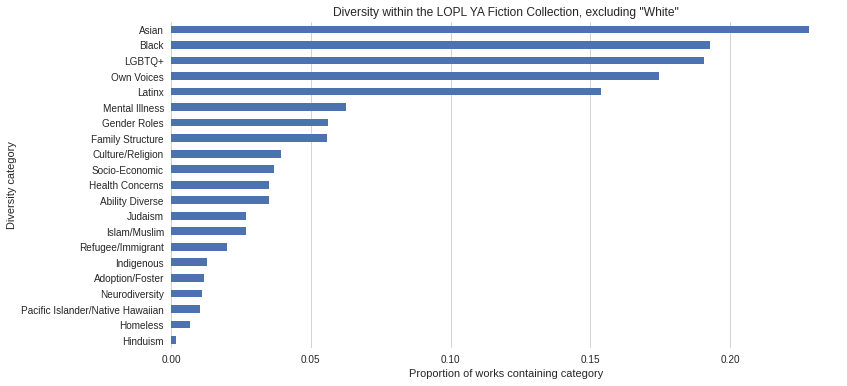

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
audit_df[audit_columns].drop('White',axis=1).mean(axis=0).sort_values().plot.barh()
plt.title('Diversity within the LOPL YA Fiction Collection, excluding "White"')
ax.set_xlabel('Proportion of works containing category')
ax.set_ylabel('Diversity category')
plt.grid(axis='x')
plt.show()

**Ideally, we'd like to look not just at the composition of the collection itself, but also how this composition compares to that of the broader community of Lake Oswego. Let's pull data from the US Census Bureau's 2019 American Community Survey to get a clearer sense of community demographics.**

In [19]:
!pip install censusdata
import censusdata

     |████████████████████████████████| 30.3MB 128kB/s 
  Created wheel for censusdata: filename=CensusData-1.13-cp37-none-any.whl size=32269382 sha256=fd34bcf9e6260e55b12e66baf77e4905f70d36ce22375411d917724e0918ed3c
  Stored in directory: /root/.cache/pip/wheels/e4/7f/e0/7fbb20cef77b96b59344deaf633a1dc571f76f229d4a06074e
Successfully built censusdata


In [20]:
lake_oswego_geocode = censusdata.censusgeo([('state', '41'), ('place', '40550')])

In [21]:
# this is all ages, but it's possible to limit to specific age brackets: 10-14, 15-17, 18-19, 20, 21
race_table_metadata = censusdata.censustable('acs5', 2019, 'B02001')
race_table_vars = list(race_table_metadata.keys())[:6]
race_table = censusdata.download('acs5', 2019, lake_oswego_geocode, race_table_vars)


In [22]:
race_table_columns = ['Total','White','Black','Indigenous','Asian','Pacific Islander/Native Hawaiian']
race_table.columns = race_table_columns
race_table.reset_index(inplace=True, drop=True)
race_table

,Total,White,Black,Indigenous,Asian,Pacific Islander/Native Hawaiian
0,39127,33567,405,286,2404,173


In [23]:
lake_oswego_population = race_table.loc[0,'Total']
proportions_table = race_table / lake_oswego_population
proportions_table = proportions_table.drop('Total', axis=1)

In [24]:
hispanic_table_metadata = censusdata.censustable('acs5', 2019, 'B03001')
hispanic_table_vars = list(hispanic_table_metadata.keys())[:3]
hispanic_table = censusdata.download('acs5', 2019, lake_oswego_geocode, hispanic_table_vars)

In [25]:
hispanic_table.columns = ['Total','Not Hispanic or Latino', 'Hispanic or Latino']
hispanic_table.reset_index(inplace=True, drop=True)
hispanic_proportion = hispanic_table.loc[0,'Hispanic or Latino'] / hispanic_table.loc[0,'Total']

proportions_table['Latinx'] = hispanic_proportion

In [26]:
immigration_table_info = censusdata.censustable('acs5', 2019, 'B05002')

immigrant_table = censusdata.download('acs5', 2019, lake_oswego_geocode, ['B05002_009E'])
immigrant_table.reset_index(inplace=True, drop=True)
immigrant_proportion = (immigrant_table.loc[0,'B05002_009E'] / lake_oswego_population)

proportions_table['Refugee/Immigrant'] = immigrant_proportion

In [27]:
neurodiversity_table_info = censusdata.censustable('acs5', 2019, 'B18104')
neurodiversity_table_info
neurodiversity_vars = ['B18104_004E', 'B18104_007E','B18104_010E','B18104_013E','B18104_016E', 'B18104_020E','B18104_023E','B18104_026E','B18104_029E','B18104_032E']
neurodiversity_table = censusdata.download('acs5', 2019, lake_oswego_geocode, neurodiversity_vars)
neurodiverse_population = neurodiversity_table.values.sum()
neurodiverse_proportion = neurodiverse_population / lake_oswego_population
proportions_table['Neurodiversity'] = neurodiverse_proportion

In [28]:
# Should this be limited to specific age range?

ability_table_info = censusdata.censustable('acs5', 2019, 'B18101')
ability_table_info
ability_vars = ['B18101_004E', 'B18101_007E','B18101_010E','B18101_013E','B18101_016E', 'B18101_019E','B18101_023E','B18101_026E','B18101_029E','B18101_032E', 'B18101_035E', 'B18101_038E']
ability_table = censusdata.download('acs5', 2019, lake_oswego_geocode, ability_vars)
ability_population = ability_table.values.sum()
ability_proportion = ability_population / lake_oswego_population
proportions_table['Ability Diverse'] = ability_proportion

In [29]:
adopted_children = censusdata.download('acs5', 2019, lake_oswego_geocode, ['B09019_016E']).values
proportions_table['Adoption/Foster'] = adopted_children / lake_oswego_population

In [30]:
# According to the Williams Institute, approximately 5.6% of Oregon's population identifies as LGBTQ+
proportions_table['LGBTQ+'] = 0.056

In [31]:
proportions_table.index=['LOPL Census']
proportions_table = proportions_table.T

In [32]:
cols = ['Black', 'Asian', 'Latinx', 'Indigenous', 'White', 'Pacific Islander/Native Hawaiian', 'Refugee/Immigrant', 'LGBTQ+', 'Neurodiversity','Ability Diverse','Adoption/Foster']
collection_proportions = pd.DataFrame(audit_df[cols].mean(axis=0).sort_values(ascending=False))
collection_proportions.columns = ['LOPL YA Collection']
ratios_df = pd.concat([collection_proportions, proportions_table], axis=1)

**Now that we have the data gathered, let's look at the demographic makeup of Lake Oswego.**

In [33]:
ratios_df['LOPL Census'].sort_values() * 100

Pacific Islander/Native Hawaiian     0.442150
Adoption/Foster                      0.649168
Indigenous                           0.730953
Black                                1.035091
Refugee/Immigrant                    2.019066
Neurodiversity                       3.084826
Latinx                               5.175454
LGBTQ+                               5.600000
Asian                                6.144095
Ability Diverse                      7.833465
White                               85.789864
Name: LOPL Census, dtype: float64

**Lake Oswego is predominantly white, much like the Portland metro area and Oregon as whole. Now that we have a good handle on the demographic makeup of the city, let's compare the census data and the collection data side-by-side.**

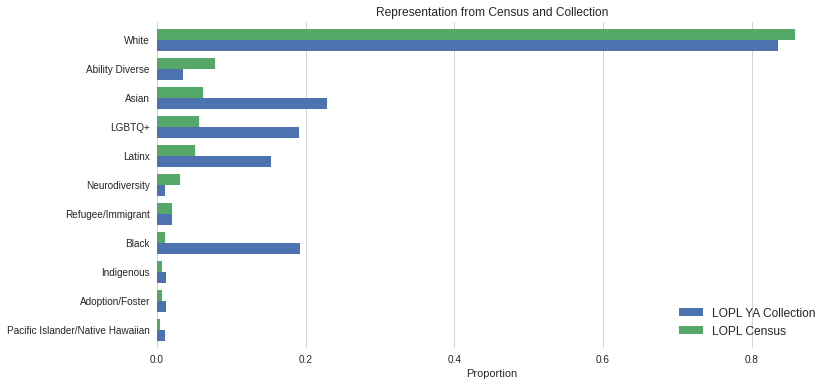

In [34]:
ratios_df[['LOPL YA Collection','LOPL Census']].sort_values('LOPL Census').plot.barh(figsize=(12,6), width=.75)
plt.legend(fontsize=12, loc='lower right')
plt.title('Representation from Census and Collection')
plt.xlabel('Proportion')
plt.grid(axis='x')
plt.show()

**As before, we can remove the "White" category from the visualization to get a closer look at the other categories.**

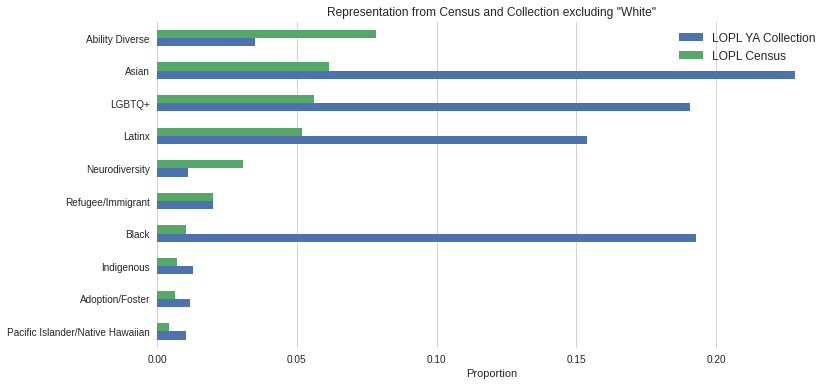

In [35]:
ratios_df[['LOPL YA Collection','LOPL Census']].drop('White',axis=0).sort_values('LOPL Census').plot.barh(figsize=(12,6))
plt.legend(fontsize=12)
plt.title('Representation from Census and Collection excluding "White"')
plt.xlabel('Proportion')
plt.grid(axis='x')
plt.show()

**We can see in the table above that there's a wide range of bar length variation between the census data and the collection itself. If we compare the length of these bars, we can produce a rough metric of how over/underrepresented various populations or topics are within the collection.**

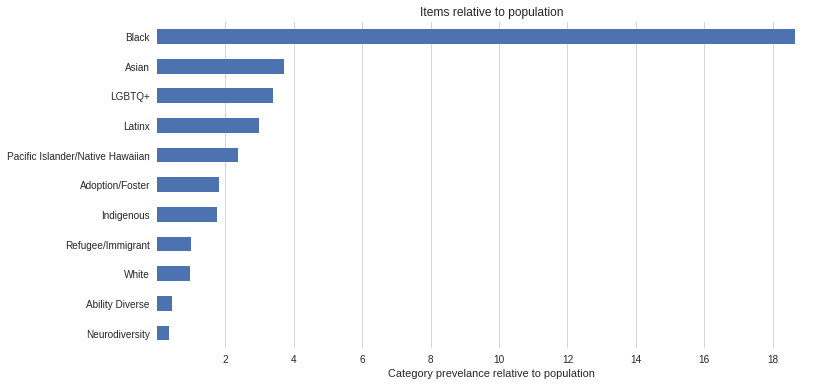

In [36]:
ratios_df['representation_ratio'] = ratios_df['LOPL YA Collection'] / ratios_df['LOPL Census']
ratios_df['representation_ratio'].sort_values().plot.barh(figsize=(12,6))
plt.xticks(range(2,20,2))
plt.title('Items relative to population')
plt.xlabel('Category prevelance relative to population')
plt.grid(axis='x')
plt.show()


**The dataset is also provided with information about how much each item has circulated over its entire time in the collection. **

In [37]:
melted = audit_df.melt(id_vars=['Total Charges'], value_vars=audit_columns, var_name='Diversity Category')
melted = melted[melted['value']].drop('value', axis=1)
charges_df = melted.pivot_table(index='Diversity Category', values='Total Charges', aggfunc=[np.mean, np.median, np.sum])
charges_df.columns = ['mean', 'median','sum']
charges_df = charges_df.sort_values('mean')

**The chart below can help visualize the relative popularity of different topics. The green bars show the average number of checkouts for books that contain each topic. Blue bars represent thae median number of checkouts for titles that contain each category. The greater the difference in the length of these bars, the more each topic's checkouts are dominated by a small number of titles.**

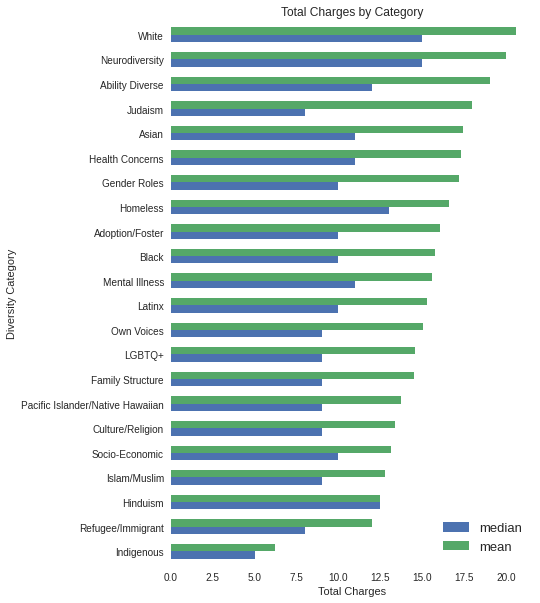

In [38]:
charges_df[['median','mean']].plot.barh(legend=False, figsize=(6.5,10), width=.6)
plt.title('Total Charges by Category')
plt.xlabel('Total Charges')
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [39]:
ov_dict = {}
for col in audit_columns[:-1]:
   total = audit_df[col].sum()
   ov = (audit_df[col] & audit_df['Own Voices']).sum()
   ov_dict[col] = [ov/total, ov]
   #print('{} is {:.1%} own voices'.format(col, ov/total))



In [40]:
ov_df  = pd.DataFrame.from_dict(ov_dict, orient='index', columns=['Average Charges','Total'])


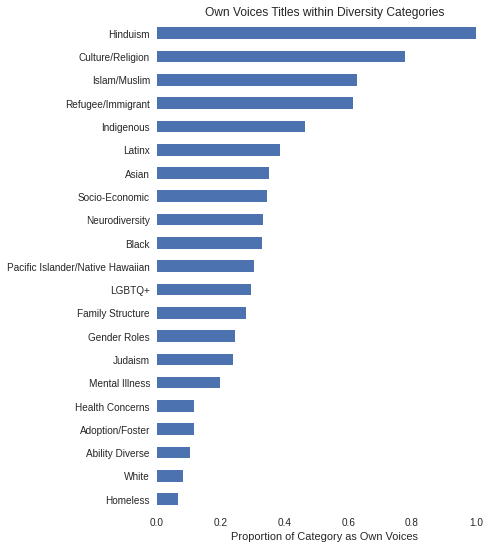

In [41]:
ov_df.sort_values('Average Charges').plot.barh(y='Average Charges',figsize=(6,9), legend=False)
plt.title('Own Voices Titles within Diversity Categories')
plt.xlabel('Proportion of Category as Own Voices')
plt.show()

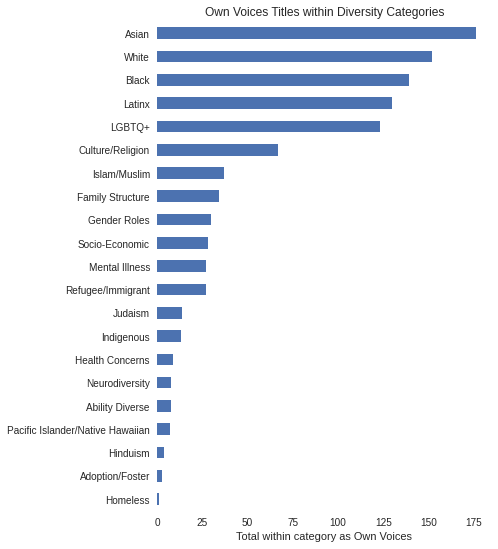

In [42]:
ov_df.sort_values('Total').plot.barh(y='Total',figsize=(6,9), legend=False)
plt.title('Own Voices Titles within Diversity Categories')
plt.xlabel('Total within category as Own Voices')
plt.show()

In [43]:
# how does this collection compare to reports from the publishing industry?
# CCBC studies

**How has the diversity of the collection varied over time? Let's look at the raw average number of diversity categories present for titles added in each year**

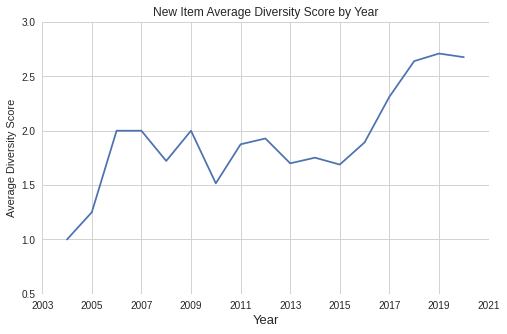

In [44]:
audit_df['Item Created Date'] = pd.to_datetime(audit_df['Item Created Date'])
audit_df['Item Added Year'] = audit_df['Item Created Date'].apply(lambda x: x.year)
diversity_by_year = audit_df.groupby('Item Added Year')['diversity_score'].agg(['mean'])

fig, ax = plt.subplots(figsize=(8,5))
diversity_by_year = diversity_by_year[diversity_by_year.index > 2003]

plt.plot(diversity_by_year.index, diversity_by_year)
plt.title('New Item Average Diversity Score by Year')
plt.xlabel('Year', fontsize=13)
plt.ylabel('Average Diversity Score')
plt.yticks([.5,1,1.5,2,2.5,3])
plt.xticks(range(2003,2022,2))
plt.grid()
plt.show()

**Simply counting the raw number of diveristy categories represented in titles can tell an incomplete picture. For example, an increase in titles featuring the same two categories would cause the graph above to show an upward trend. We want to look more comprehensively at the diversity of the titles. We can create a code for each unique combination of diversity categories, and then apply a diversity metric. We'll be using Shannon's Diversity Index. https://en.wikipedia.org/wiki/Diversity_index**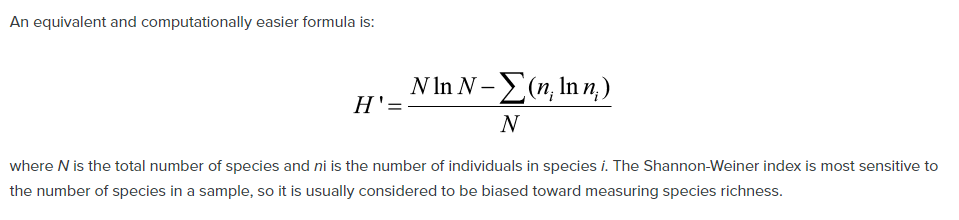

In [45]:
audit_df['code'] = audit_df[audit_columns].astype(int).astype(str).agg(''.join, axis=1)
codes_by_year = audit_df.groupby('Item Added Year')['code'].value_counts()

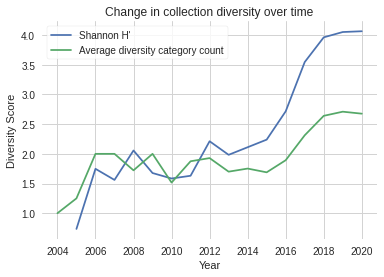

In [46]:
div_by_year = []

# calculate Shannon Diversity Score. 
for year in codes_by_year.index.levels[0]:
  year_values = codes_by_year[year].sort_values(ascending=False).values
  year_values = year_values[year_values>0]
  log_year_values = np.log(year_values)
  N = year_values.sum()
  shannon_H = (N * np.log(N) - (year_values * log_year_values).sum())/N
  div_by_year.append(shannon_H)

plt.plot(codes_by_year.index.levels[0][2:], div_by_year[2:], label='Shannon H\'')
plt.plot(diversity_by_year.index, diversity_by_year, label='Average diversity category count')
plt.legend(loc='upper left', facecolor='w', frameon=True)
plt.title('Change in collection diversity over time')
plt.xlabel('Year')
plt.ylabel('Diversity Score')
plt.grid()
plt.show()

****

**As we can see, the simple average of diversity categories underrepresents the true increase in the diversity of the collection. The chart above shows a strong upward trend in the diversity present within the collection, starting in around 2015. Let's look at how the composition of the collection differed from before and after this trend began. Below, where green bars are longer than blue bars, the LOPL YA Collection has increased the relative proportion of titles featuring the associated diversity category.**

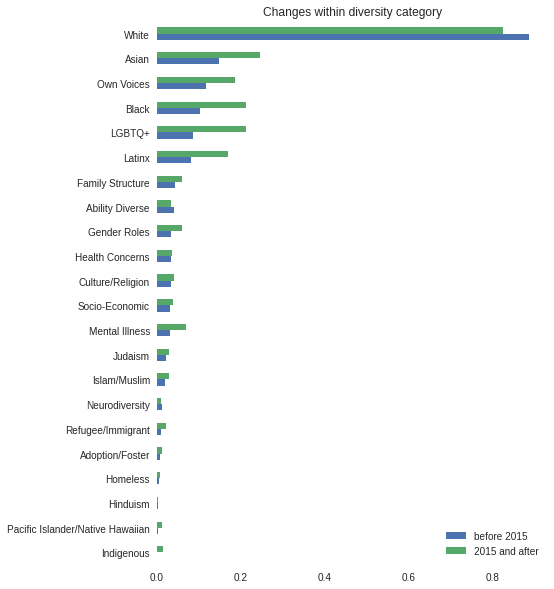

In [47]:
cutoff_year = 2015
by_year = audit_df.loc[audit_df['Item Added Year']<cutoff_year,audit_columns].mean(axis=0).to_frame()
by_year.columns = ['before {}'.format(cutoff_year)]
by_year['{} and after'.format(cutoff_year)] = audit_df.loc[audit_df['Item Added Year']>=cutoff_year,audit_columns].mean(axis=0).to_frame()
by_year = by_year.sort_values(by_year.columns[0])
by_year.plot.barh(figsize=(7,10))
plt.legend(loc = 'lower right')
plt.title('Changes within diversity category')
plt.show()

**The average diversity score of newly acquired titles has been rising noticeably in the past five years. Are titles with more diversity categories present circulating more or less? We'll need to account for the fact that the "Total Charges" data is over the lifetime of the title's inclusion in the selection. Older titles will have had more time to circulate, after all. Unfortunately, this metric will suffer from survivorship bias, as items with poor circulation are more likely to be removed from the collection.**

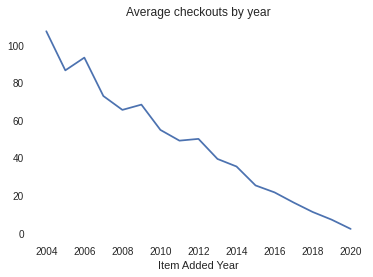

In [48]:
# removing 1997, since there's just a single entry
audit_df[audit_df['Item Added Year']>1998].groupby('Item Added Year')['Total Charges'].mean().plot()
plt.title('Average checkouts by year')
plt.show()

**Below we can see the 'survivorship bias' mentioned above. Older titles that have been retained in the collection are on average less diverse, but have circulated more.**

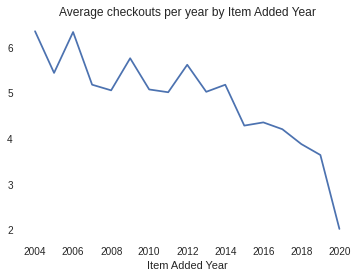

In [49]:
from datetime import datetime
audit_df['Days in Collection'] = audit_df['Item Created Date'].apply(lambda x: (datetime.today() - x).days)
audit_df['Charges per year'] = audit_df['Total Charges'] / (audit_df['Days in Collection'] / 365)

audit_df[audit_df['Item Added Year']>1998].groupby('Item Added Year')['Charges per year'].mean().plot()
plt.title('Average checkouts per year by Item Added Year')
plt.ylabel('')
plt.show()

**If we look at average number of checkouts per year relative to the diversity score, we can see that accounting for the age of the item has removed much of the variability in the number of checkouts.**

Text(0.5, 1.0, 'Average checkouts per year by Item Added Year')

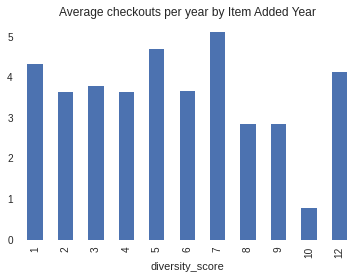

In [50]:
audit_df[audit_df['Item Added Year']>1998].groupby('diversity_score')['Charges per year'].mean().plot.bar()
plt.title('Average checkouts per year by Item Added Year')

**We can also try to account for the survivorship bias by running a linear regression analysis on the data. We're curious as to how the age and diversity score of an item impact the number of total checkouts for that item.**

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

linreg = LinearRegression()
scaler = StandardScaler()
linreg_data = audit_df[['Charges per year','diversity_score','Total Charges']].dropna(how='any', axis=0).values
X = linreg_data[:,[0,1]]
y = linreg_data[:,2]

X_scaled = scaler.fit_transform(X)

linreg.fit(X,y)
print(linreg.score(X, y))
age_factor, diversity_factor = linreg.coef_



0.5542804490539994


In [52]:
age_factor

5.89899454594494

In [53]:
diversity_factor

-1.8874711245773177

(array([240., 237., 251., 210., 210.,  79., 175., 131., 104.,  95.,  52.,
         33.,  63.,  31.,  27.,  39.,  14.,  26.,  23.,  21.,  15.,  12.,
         10.,   8.,  18.,   4.,   6.,   4.,   6.,  10.,   7.,   3.,   3.,
          1.,   6.,   1.,   3.,   1.,   0.,   2.,   1.,   2.,   0.,   0.,
          0.,   1.,   0.,   0.,   2.,   2.]),
 array([  0.  ,   2.82,   5.64,   8.46,  11.28,  14.1 ,  16.92,  19.74,
         22.56,  25.38,  28.2 ,  31.02,  33.84,  36.66,  39.48,  42.3 ,
         45.12,  47.94,  50.76,  53.58,  56.4 ,  59.22,  62.04,  64.86,
         67.68,  70.5 ,  73.32,  76.14,  78.96,  81.78,  84.6 ,  87.42,
         90.24,  93.06,  95.88,  98.7 , 101.52, 104.34, 107.16, 109.98,
        112.8 , 115.62, 118.44, 121.26, 124.08, 126.9 , 129.72, 132.54,
        135.36, 138.18, 141.  ]),
 <a list of 50 Patch objects>)

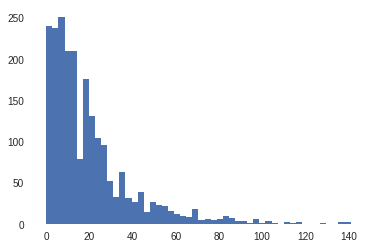

In [54]:
plt.hist(y, bins=50)

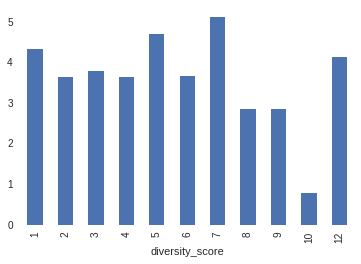

In [56]:
audit_df.groupby('diversity_score')['Charges per year'].mean().plot.bar()